In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import ltspice
import subprocess
import pickle

In [3]:
# loading parameters
# Read the variables from the file
with open("Model\\parameters.pkl", "rb") as file:
    data = pickle.load(file)

# Access variables from the dictionary
n = data["n"]
m = data["m"]
I = data["I"]
RF_finger = data["RF_finger"]
RB_finger = data["RB_finger"]
RG_finger = data["RG_finger"]
RF_busbar = data["RF_busbar"]
RB_busbar = data["RB_busbar"]
RG_busbar = data["RG_busbar"]
Rshunt = data["Rshunt"]
Rseries = data["Rseries"]
Rpogo = data["RPogo_pin"]
Probe_bottom = data["Probe_bottom"]
V_Probe_top = data["V_Probe_top"]
F_Probe_top = data["F_Probe_top"]

In [4]:
#make a log file for this simulation set (change this file name for each directory)
folder_name = "sim1"
file_path = "Model\\sim1\\"
net_name = "solar_cell"

creating the top, finite elements and bottom grid

In [5]:
def netlist_solar_cell_fin_ele(Rsh, Rsr, I, indx, indy):
#     netlist =f"""
# I{indx}_{indy} T{indx}_{indy} N{indx}_{indy} {I}
# D{indx}_{indy} N{indx}_{indy} T{indx}_{indy} D
# Rshunt{indx}_{indy} N{indx}_{indy} T{indx}_{indy} {Rsh}
# Rseries{indx}_{indy} B{indx}_{indy} N{indx}_{indy} {Rsr}
# """
    netlist =f"""
I{indx}_{indy} T{indx}_{indy} N{indx}_{indy} {I}
D{indx}_{indy} N{indx}_{indy} T{indx}_{indy} D
Rshunt{indx}_{indy} N{indx}_{indy} T{indx}_{indy} {Rsh}
Rseries{indx}_{indy} G{indx}_{indy} N{indx}_{indy} {Rsr}
"""

    return netlist

def netlist_solar_cell_top_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    # for j in range(0, m+1):  # Loop through rows of fingers
    #     for i in range(0, n):  # Loop through columns of fingers
    #         line = f"RF_f{i}_{j} T{i}_{j} T{i+1}_{j} {R_fingers[j][i]}\n"
    #         netlist += line  # Add to the netlist
    for i in range(0,m+2):
        for j in range(0,n+2):
            if(i>=1 and i<=m):
                if(j<=n):
                   line = f"RF_f{i-1}_{j} T{i}_{j} T{i}_{j+1} {R_fingers[i-1][j]}\n"
                   netlist += line

    # Rows - Busbars
    # for i in range(0, n+1):  # Loop through columns of busbars
    #     for j in range(0, m):  # Loop through rows of busbars
    #         line = f"RF_b{i}_{j} T{i}_{j} T{i}_{j+1} {R_bb[i][j]}\n"
    #         netlist += line  # Add to the netlist
    for j in range(0,n+2):
        for i in range(0,m+2):
            if(j>=1 and j<=n):
                if(i<=m):
                   line = f"RF_b{i}_{j-1} T{i}_{j} T{i+1}_{j} {R_bb[i][j-1]}\n"
                   netlist += line
    return netlist

def netlist_solar_cell_bottom_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    # for j in range(0, m):  # Loop through rows of fingers
    #     for i in range(0, n):  # Loop through columns of fingers
    #         line = f"RB_f{i}_{j} B{i}_{j} B{i+1}_{j} {R_fingers[j][i]}\n"
    #         netlist += line  # Add to the netlist
    for i in range(0,m+2):
        for j in range(0,n+2):
            if(i>=1 and i<=m):
                if(j<=n):
                #    line = f"RB_f{i-1}_{j} B{i}_{j} B{i}_{j+1} {R_fingers[i-1][j]}\n"
                   line = f"RB_f{i-1}_{j} G{i}_{j} G{i}_{j+1} {R_fingers[i-1][j]}\n"
                   netlist += line    
    # Rows - Busbars
    # for i in range(0, n):  # Loop through columns of busbars
    #     for j in range(0, m):  # Loop through rows of busbars
    #         line = f"RB_b{i}_{j} B{i}_{j} B{i}_{j+1} {R_bb[i][j]}\n"
    #         netlist += line  # Add to the netlist
    for j in range(0,n+2):
        for i in range(0,m+2):
            if(j>=1 and j<=n):
                if(i<=m):
                #    line = f"RB_b{i}_{j-1} B{i}_{j} B{i+1}_{j} {R_bb[i][j-1]}\n"
                   line = f"RB_b{i}_{j-1} G{i}_{j} G{i+1}_{j} {R_bb[i][j-1]}\n"
                   netlist += line
    return netlist

def netlist_gold_chuck_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    # for j in range(0, m):  # Loop through rows of fingers
    #     for i in range(0, n):  # Loop through columns of fingers
    #         line = f"RB_f{i}_{j} B{i}_{j} B{i+1}_{j} {R_fingers[j][i]}\n"
    #         netlist += line  # Add to the netlist
    for i in range(0,m+2):
        for j in range(0,n+2):
            if(i>=1 and i<=m):
                if(j<=n):
                   line = f"RG_f{i-1}_{j} G{i}_{j} G{i}_{j+1} {R_fingers[i-1][j]}\n"
                   netlist += line    
    # Rows - Busbars
    # for i in range(0, n):  # Loop through columns of busbars
    #     for j in range(0, m):  # Loop through rows of busbars
    #         line = f"RB_b{i}_{j} B{i}_{j} B{i}_{j+1} {R_bb[i][j]}\n"
    #         netlist += line  # Add to the netlist
    for j in range(0,n+2):
        for i in range(0,m+2):
            if(j>=1 and j<=n):
                if(i<=m):
                   line = f"RG_b{i}_{j-1} G{i}_{j} G{i+1}_{j} {R_bb[i][j-1]}\n"
                   netlist += line
    return netlist

def netlist_V_source():
    netlist = f"V1 Vpos 0 DC 0\n"
    return netlist

def netlist_simtype():
    netlist = ".dc V1 0 0.8 0.01\n"
    return netlist

In [6]:
def solar_cell_netlist():

    # Initialize the netlist with the header
    netlist = """*C:\\Users\\ASUS\\Desktop\\Semesters\\Sem 8\\BTP\\Simulation\\finite_element_model\\"""
    netlist += file_path
    netlist += net_name + '.asc\n'
    
    # top resistance grid
    # nodes from T00 to Tnn
    netlist += netlist_solar_cell_top_ele(RF_finger, RF_busbar, n, m)

    # finite element
    # for i in range(0,n):
    #     for j in range(0,m):
    #         netlist += netlist_solar_cell_fin_ele(Rshunt[i][j], Rseries[i][j], I, i, j)
    for i in range(1,m+1):
        for j in range(1,n+1):
            netlist += netlist_solar_cell_fin_ele(Rshunt[i-1][j-1], Rseries[i-1][j-1], I, i, j)
    
    # bottom resistance grid
    # nodes from B00 to Bnn
    netlist += netlist_solar_cell_bottom_ele(RB_finger, RB_busbar, n, m)

    # chuck resistance grid
    # nodes from G00 to Gnn
    netlist += netlist_gold_chuck_ele(RG_finger, RG_busbar, n, m)

    # adding the voltage source
    netlist += netlist_V_source()

    for (x,y) in Probe_bottom:
        # netlist = netlist.replace(f" B{x}_{y}", " Vpos")
        netlist += f"RpogoB{x}_{y} G{x}_{y} Vpos {Rpogo}\n"
    
    # for (x,y) in Probe_neg:
    #     # netlist = netlist.replace(f" T{x}_{y}", " 0")
    #      netlist += f"RpogoT{x}_{y} T{x}_{y} 0 {Rpogo}\n"

    for (x,y) in F_Probe_top:
        # netlist = netlist.replace(f" T{x}_{y}", " 0")
         netlist += f"RpogoT{x}_{y} T{x}_{y} 0 {Rpogo}\n"

    for (x,y) in V_Probe_top:
        # netlist = netlist.replace(f" T{x}_{y}", " 0")
         netlist += f"RpogoT{x}_{y} T{x}_{y} M_top {Rpogo}\n"

    # adding the simulation type
    netlist += netlist_simtype()

    # Add the footer
    netlist += """.model D D
.lib C:\\Users\\ASUS\\AppData\\Local\\LTspice\\lib\\cmp\\standard.dio
.backanno
.end"""

    return netlist


output_file = file_path + net_name +'.net'
with open(output_file, 'w') as file:
    file.write(solar_cell_netlist())

now i have the netlist ready lets try simulating it!

In [7]:
# Path to LTSpice executable
ltspice_exe = 'C:\\Program Files\\ADI\\LTspice\\LTspice.exe'

def RunLTsimulation(netlist_file):
    # Run LTSpice simulation
    subprocess.run([ltspice_exe, '-b', netlist_file], check=True)

# Path to the netlist file
netlist_file = output_file 

#running simulation
RunLTsimulation(netlist_file)

# Extract data
# Load the LTSpice data
lt = ltspice.Ltspice(file_path + net_name +'.raw')
lt.parse()

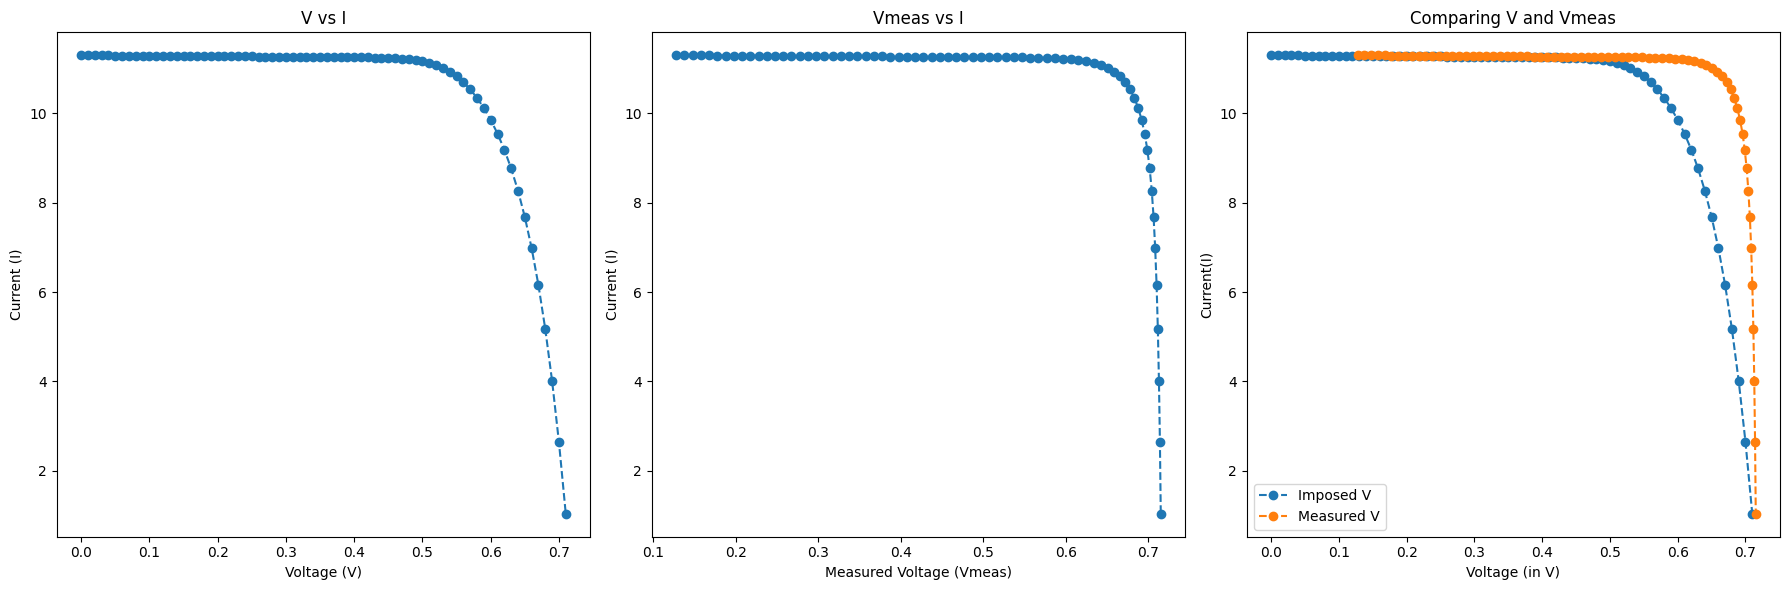

In [8]:
I = lt.get_data("I(V1)")
V = lt.get_data("v1")
Vmeas = lt.get_data("V(vpos)") - lt.get_data("V(m_top)")

zero_crossing_index = np.argmax(I <= 0)  # First index where I <= 0

# Slice the data up to the zero-crossing point
V_trimmed = V[:zero_crossing_index]
I_trimmed = I[:zero_crossing_index]
Vmeas_trimmed = Vmeas[:zero_crossing_index]


plt.figure(figsize=[18, 6])

plt.subplot(1, 3, 1)
plt.plot(V_trimmed, I_trimmed,"--o")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (I)")
plt.title("V vs I")

plt.subplot(1, 3, 2)
plt.plot(Vmeas_trimmed, I_trimmed,"--o")
plt.xlabel("Measured Voltage (Vmeas)")
plt.ylabel("Current (I)")
plt.title("Vmeas vs I")

plt.subplot(1,3,3)
plt.plot(V_trimmed, I_trimmed,"--o", label = "Imposed V")
plt.plot(Vmeas_trimmed, I_trimmed,"--o", label = "Measured V")
plt.xlabel("Voltage (in V)")
plt.ylabel("Current(I)")
plt.title("Comparing V and Vmeas")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()



In [9]:
# Voltage distribution on each finite element
VB_grid = []
VF_grid = []
I_grid = []

for i in range(1, m+1):
    for j in range(1, n+1):
        VF_grid.append(lt.get_data(f"V(t{i}_{j})"))
        VB_grid.append(lt.get_data(f"V(g{i}_{j})"))
        I_grid.append(lt.get_data(f"I(Rseries{i}_{j})"))

sz = len(I_grid[0])
I_grid = np.array(I_grid).reshape(m, n, sz)
VF_grid = np.array(VF_grid).reshape(m, n, sz)
VB_grid = np.array(VB_grid).reshape(m, n, sz)

In [10]:
F_Probe_top1 = [(x-1, y-1) for x, y in F_Probe_top]
V_Probe_top1 = [(x-1, y-1) for x, y in V_Probe_top]
Probe_bottom1 = [(x-1, y-1) for x, y in Probe_bottom]

# Extract x, y positions for probes
F_Probe_top_x, F_Probe_top_y = zip(*F_Probe_top1)
V_Probe_top_x, V_Probe_top_y = zip(*V_Probe_top1)
Probe_bottom_x, Probe_bottom_y = zip(*Probe_bottom1)

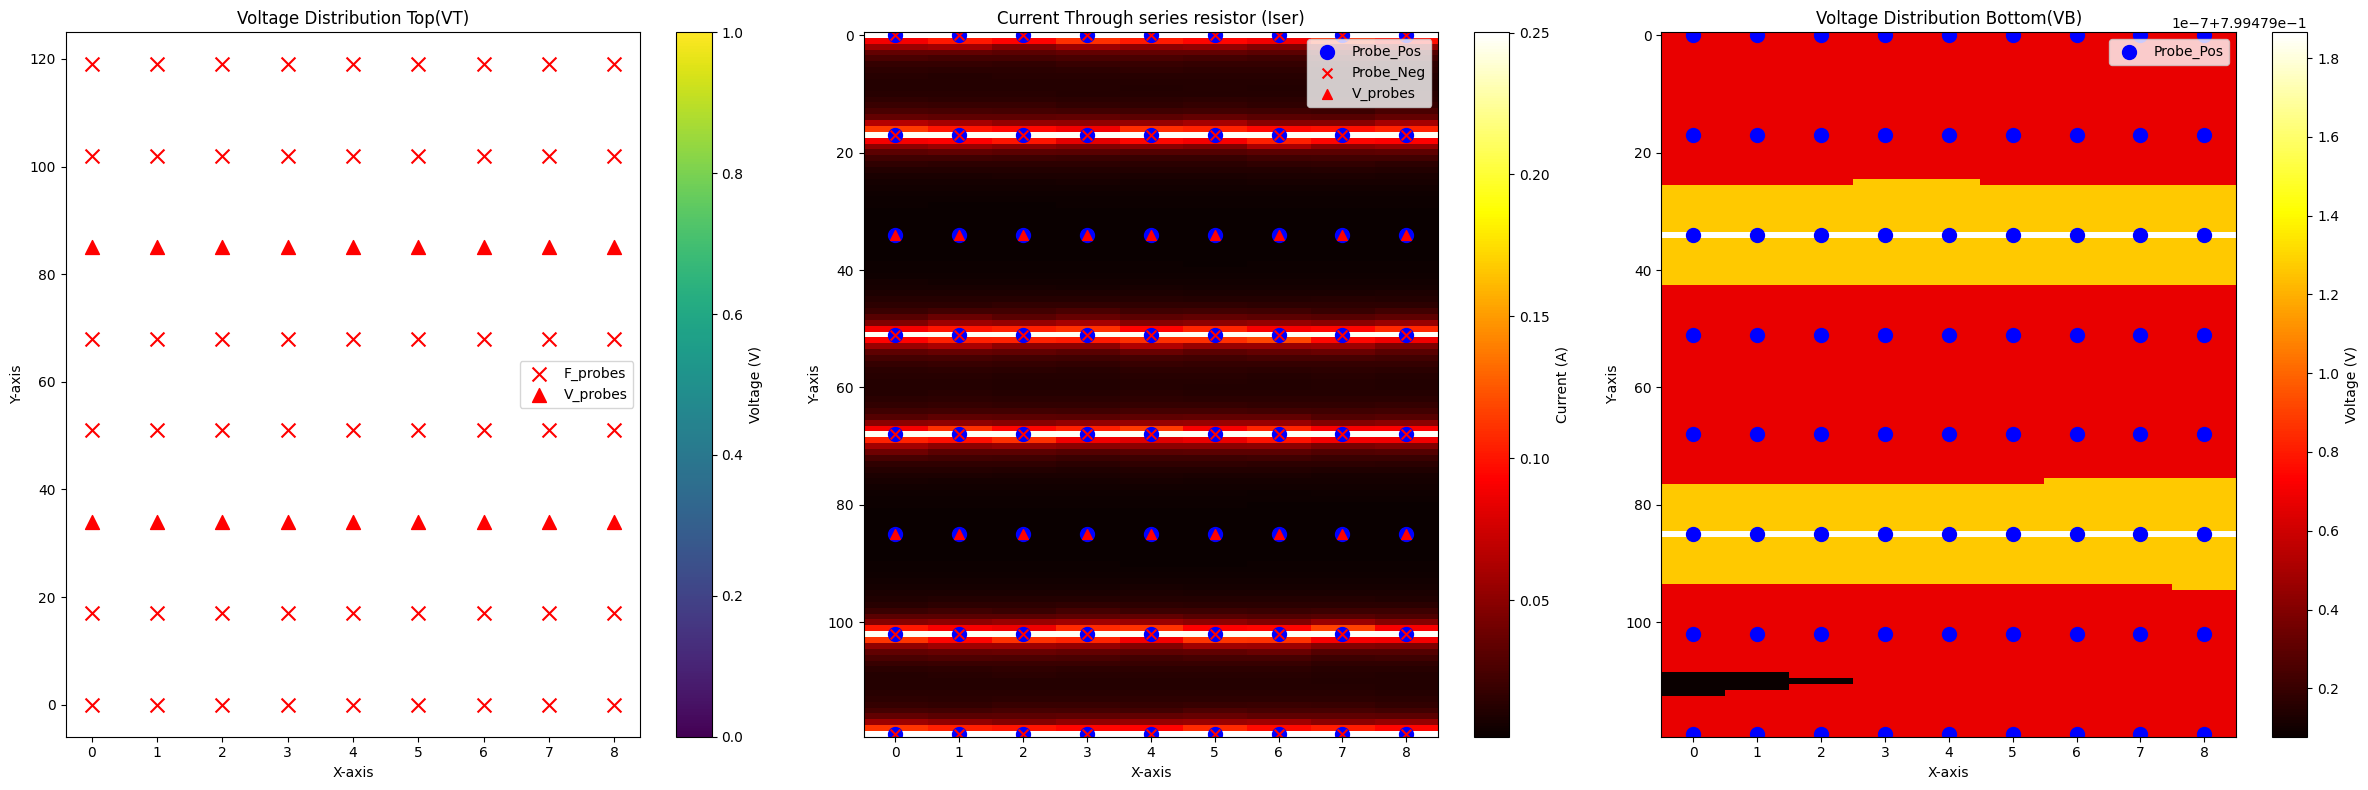

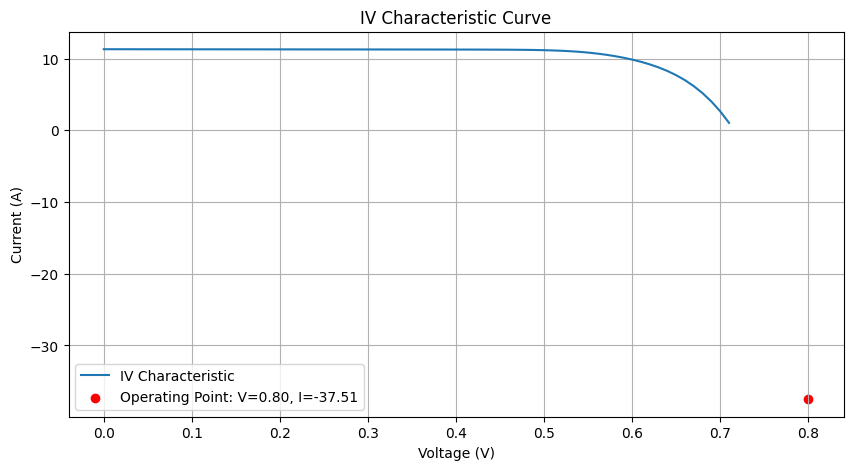

In [11]:
# Choose the slice index to visualize
slice_index = 80

# Calculate operating point (example: using the mean values at the slice index)
V_op = np.mean(V[slice_index])
I_op = np.mean(I[slice_index])


# Display the images
plt.figure(figsize=[24, 8])

# Forward Voltage (VF) plane
plt.subplot(1, 3, 1)
plt.scatter(F_Probe_top_y, F_Probe_top_x, color='red', label='F_probes', s=100, marker='x')
plt.scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=100, marker='^')
# plt.imshow(VF_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Voltage (V)')
plt.title('Voltage Distribution Top(VT)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Current (I) plane
plt.subplot(1, 3, 2)
plt.scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
plt.scatter(F_Probe_top_y, F_Probe_top_x, color='red', label='Probe_Neg', s=50, marker='x')
plt.scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=50, marker='^')
plt.imshow(I_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Current (A)')
plt.title('Current Through series resistor (Iser)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Back Voltage (VB) plane
plt.subplot(1, 3, 3)
plt.scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')  # Positive probes
plt.imshow(VB_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Voltage (V)')
plt.title('Voltage Distribution Bottom(VB)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.savefig("fin_sim_fr.pdf")
plt.tight_layout()
plt.show()

# Plot IV characteristic curve
plt.figure(figsize=[10, 5])
plt.plot(V_trimmed,I_trimmed, label='IV Characteristic')
plt.scatter(V_op, I_op, color='red', label=f'Operating Point: V={V_op:.2f}, I={I_op:.2f}')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('IV Characteristic Curve')
plt.legend()
plt.grid(True)
plt.savefig("fin_sim_IV.pdf")
plt.show()

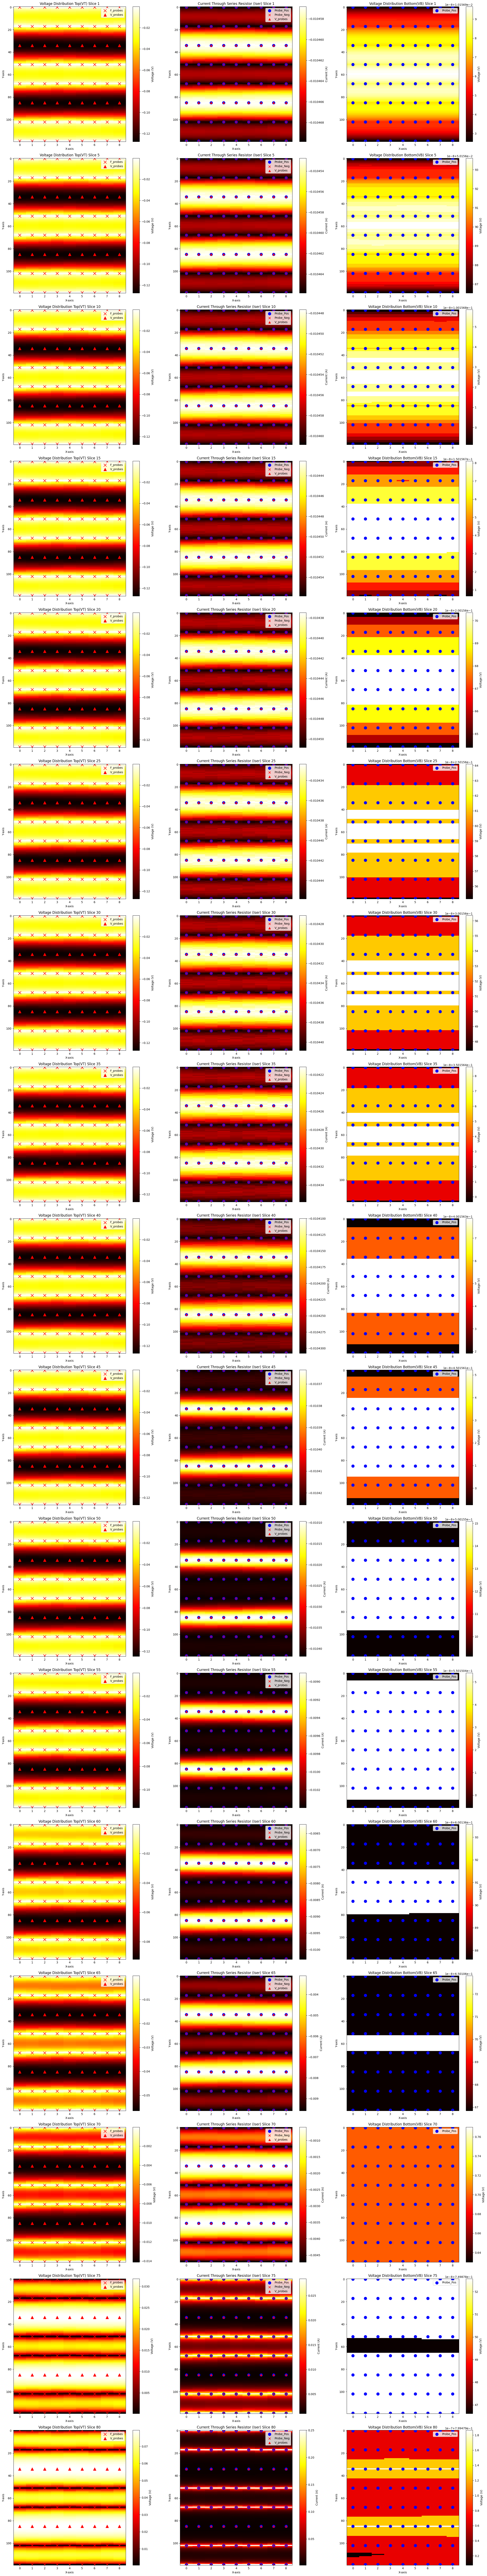

In [12]:
# List of slice indices
slice_indices = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

# Set up the figure and subplots (17x3 grid)
fig, axes = plt.subplots(17, 3, figsize=[24, 126])

# Loop through the slice indices and plot in each subplot
for idx, slice_index in enumerate(slice_indices):
    row = idx  # Row index (corresponds to slice_index)
    
    # Forward Voltage (VF) plane
    axes[row, 0].scatter(F_Probe_top_y, F_Probe_top_x, color='red', label='F_probes', s=100, marker='x')
    axes[row, 0].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=100, marker='^')
    im1 = axes[row, 0].imshow(VF_grid[:, :, slice_index], aspect='auto', cmap='hot')
    axes[row, 0].set_title(f'Voltage Distribution Top(VT) Slice {slice_index}')
    axes[row, 0].set_xlabel('X-axis')
    axes[row, 0].set_ylabel('Y-axis')
    axes[row, 0].legend()
    fig.colorbar(im1, ax=axes[row, 0], label='Voltage (V)')
    
    # Current (I) plane
    axes[row, 1].scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
    axes[row, 1].scatter(F_Probe_top_y, F_Probe_top_x, color='red', label='Probe_Neg', s=50, marker='x')
    axes[row, 1].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=50, marker='^')
    im2 = axes[row, 1].imshow(I_grid[:, :, slice_index], aspect='auto', cmap='hot')
    axes[row, 1].set_title(f'Current Through Series Resistor (Iser) Slice {slice_index}')
    axes[row, 1].set_xlabel('X-axis')
    axes[row, 1].set_ylabel('Y-axis')
    axes[row, 1].legend()
    fig.colorbar(im2, ax=axes[row, 1], label='Current (A)')
    
    # Back Voltage (VB) plane
    axes[row, 2].scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
    im3 = axes[row, 2].imshow(VB_grid[:, :, slice_index], aspect='auto', cmap='hot')
    axes[row, 2].set_title(f'Voltage Distribution Bottom(VB) Slice {slice_index}')
    axes[row, 2].set_xlabel('X-axis')
    axes[row, 2].set_ylabel('Y-axis')
    axes[row, 2].legend()
    fig.colorbar(im3, ax=axes[row, 2], label='Voltage (V)')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as a PDF
plt.savefig("fin_sim_all_slices.pdf")

# Show the plot
plt.show()


GIF saved as 'voltage_current_back_voltage.gif'


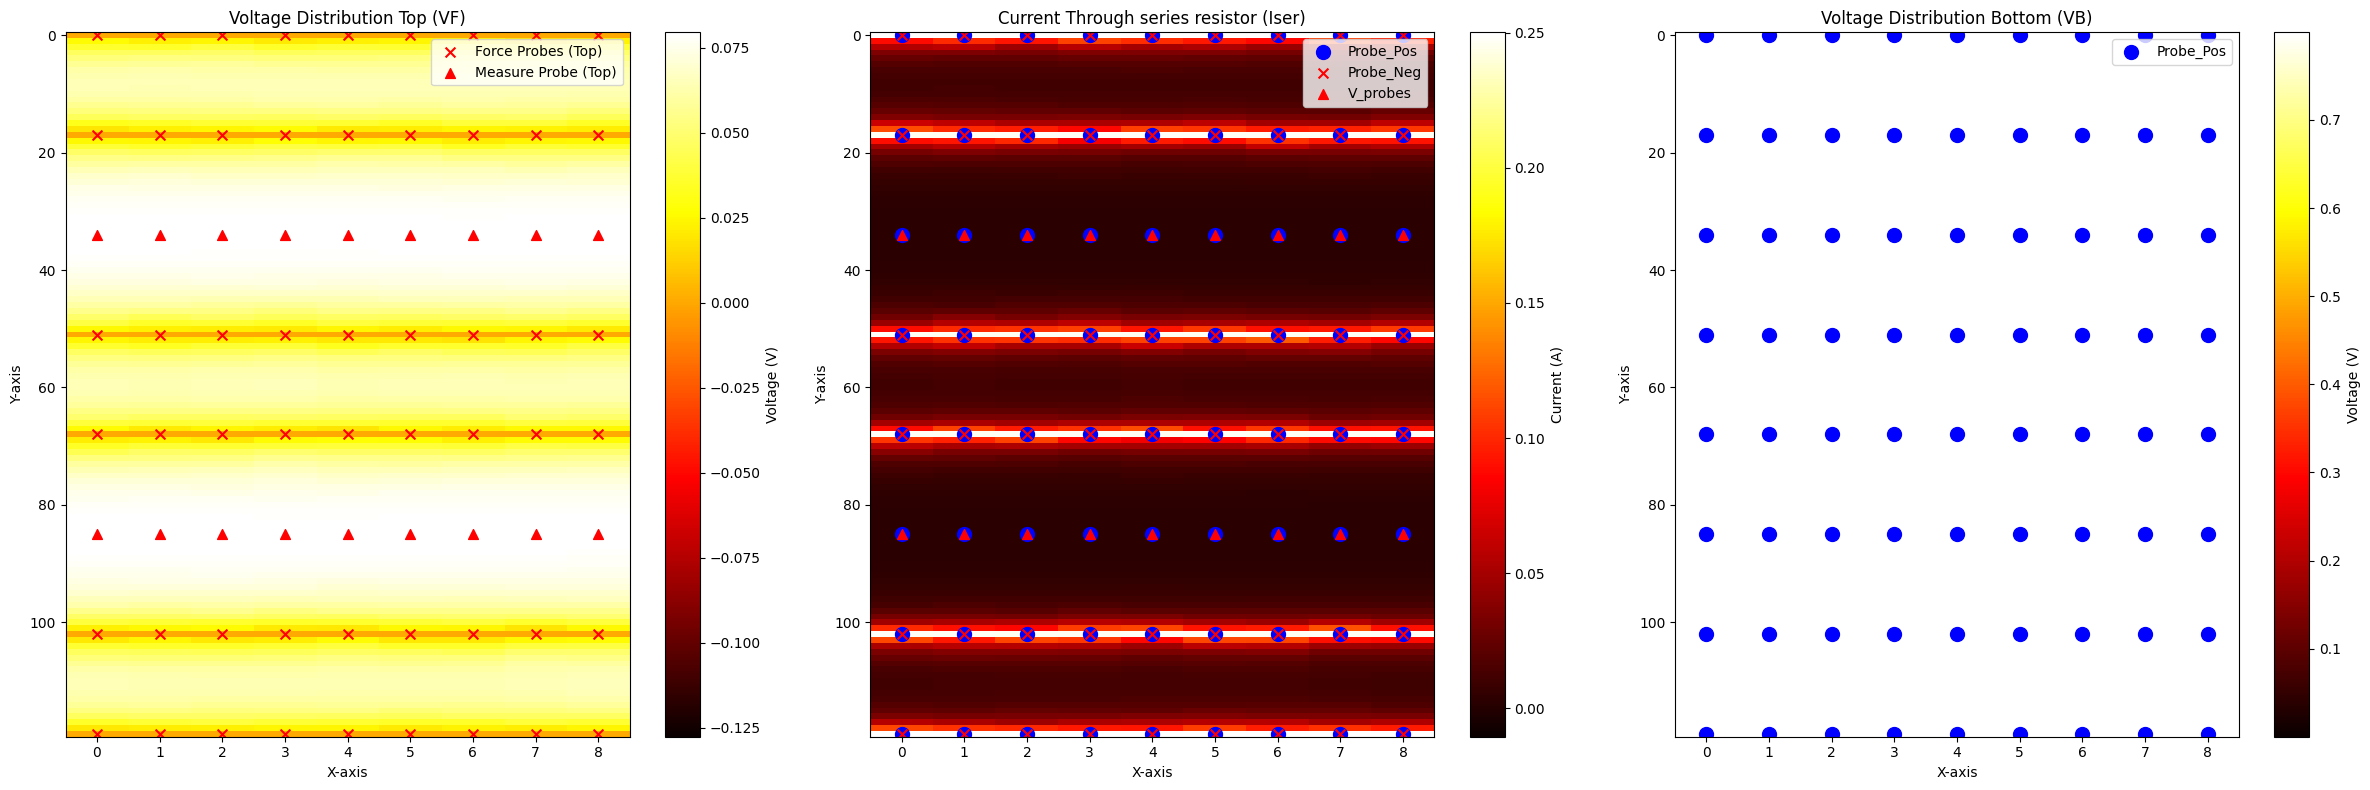

In [13]:
# Define color scale range for the selected plots (VF, I, and VB)
vmin_vf, vmax_vf = VF_grid.min(), VF_grid.max()  # Range for VF
vmin_i, vmax_i = I_grid.min(), I_grid.max()     # Range for I
vmin_vb, vmax_vb = VB_grid.min(), VB_grid.max() # Range for VB

# Initialize the figure for three subplots
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Create the initial plots for each subplot (same as the code you provided)

# Voltage (VF) plane
# ax[0].scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe (Bottom)', s=100, marker='o')
ax[0].scatter(F_Probe_top_y, F_Probe_top_x, color='red', label='Force Probes (Top)', s=50, marker='x')
ax[0].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='Measure Probe (Top)', s=50, marker='^')
im_vf = ax[0].imshow(VF_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vf, vmax=vmax_vf)
# im_vf = ax[0].imshow(VF_grid[:, :, 0], aspect="auto", cmap="hot")
fig.colorbar(im_vf, ax=ax[0], label="Voltage (V)")
ax[0].set_title("Voltage Distribution Top (VF)")
ax[0].set_xlabel("X-axis")
ax[0].set_ylabel("Y-axis")
ax[0].legend()

# Current (I) plane
ax[1].scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
ax[1].scatter(F_Probe_top_y, F_Probe_top_x, color='red', label='Probe_Neg', s=50, marker='x')
ax[1].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=50, marker='^')
im_i = ax[1].imshow(I_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_i, vmax=vmax_i)
# im_i = ax[1].imshow(I_grid[:, :, 0], aspect="auto", cmap="hot")
fig.colorbar(im_i, ax=ax[1], label="Current (A)")
ax[1].set_title("Current Through series resistor (Iser)")
ax[1].set_xlabel("X-axis")
ax[1].set_ylabel("Y-axis")
ax[1].legend()

# Back Voltage (VB) plane
ax[2].scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
im_vb = ax[2].imshow(VB_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vb, vmax=vmax_vb)
# im_vb = ax[2].imshow(VB_grid[:, :, 0], aspect="auto", cmap="hot")
fig.colorbar(im_vb, ax=ax[2], label="Voltage (V)")
ax[2].set_title("Voltage Distribution Bottom (VB)")
ax[2].set_xlabel("X-axis")
ax[2].set_ylabel("Y-axis")
ax[2].legend()

plt.tight_layout()

# Animation update function
def update(slice_index):
    # Update each subplot with the current slice index
    im_vf.set_array(VF_grid[:, :, slice_index])  # Update VF grid for the current slice index
    im_i.set_array(I_grid[:, :, slice_index])    # Update I grid for the current slice index
    im_vb.set_array(VB_grid[:, :, slice_index])  # Update VB grid for the current slice index
    return [im_vf, im_i, im_vb]  # Return all updated images

# Create the animation
anim = FuncAnimation(fig, update, frames=range(0, 81), interval=200, blit=True)

# Save the animation as a GIF
gif_writer = PillowWriter(fps=5)  # Adjust FPS for speed
anim.save("voltage_current_back_voltage.gif", writer=gif_writer)

print("GIF saved as 'voltage_current_back_voltage.gif'")